# Проект: Выбор региона для бурения новых скважин

**Оглавление**<a id='toc0_'></a>    
- 1. [Загрузка и подготовка данных](#toc1_)    
  - 1.1. [Вывод по разделу 1](#toc1_1_)    
- 2. [Обучение и проверка модели](#toc2_)    
  - 2.1. [Разбивка данных на выборки](#toc2_1_)    
  - 2.2. [Обучение модели и предсказания](#toc2_2_)    
  - 2.3. [Вывод по разделу 2](#toc2_3_)    
- 3. [Подготовка к расчёту прибыли](#toc3_)    
  - 3.1. [Вывод по разделу 3](#toc3_1_)    
- 4. [Расчёт прибыли и рисков](#toc4_)    
  - 4.1. [Вывод по разделу 4](#toc4_1_)    
- 5. [Общий вывод](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**Задание:**

Добывающей компании «ГлавРосГосНефть» необходимо выбрать регион для бурения новых скважин.

Предоставлены пробы нефти из трёх регионов (в каждом 100000 месторождений), где измерили качество нефти и объём её запасов.

Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. А также проанализировать возможную прибыль и риски техникой "Bootstrap".

План работы:
1. Загрузка и подготовка данных.
2. Обучение и проверка модели.
3. Подготовка к расчёту прибыли.
4. Расчёт прибыли и рисков.
5. Общий вывод.

## 1. <a id='toc1_'></a>[Загрузка и подготовка данных](#toc0_)

In [1]:
# подключение библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# константы
RST = 12345 # random_state

In [2]:
# функция загрузки и обзора данных
# загружает файл в датасет, отображает его параметры, дубликаты, типы данных
# на входе - имя файла, на выходе - датасет
def zagr_obz (file):
    # загрузка файла
    try:
        data = pd.read_csv('/datasets/'+file)
    except FileNotFoundError:
        data = pd.read_csv('D:/Education/Data_Science/Проекты курса DS/Проект_08/datasets/'+file)
    # загрузка описаний столбцов данных
    ind = ['id', 'f0', 'f1', 'f2', 'product']
    polya = ['уникальный идентификатор скважины', 'признак точки №1', 'признак точки №2', 'признак точки №3', 
             'объём запасов в скважине (тыс. баррелей)']
    opisanie = pd.DataFrame(data=polya, index=ind, columns=['описание'])
    # обзор данных
    print('--------------------------------------------------------\n')
    print('Данные из файла', file, ':\n')
    data.info()
    display(pd.concat([data.head(5), data.sample(5), data.tail(5)]))
    print('Количество дубликатов:', data.duplicated().sum())
    print('Количество дубликатов в идентификаторах скважин:', data['id'].duplicated().sum())
    print('Количество дубликатов в f0:', data['f0'].duplicated().sum())
    print('Количество дубликатов в f1:', data['f1'].duplicated().sum())
    print('Количество дубликатов в f2:', data['f2'].duplicated().sum())
    print('Количество дубликатов в product:', data['product'].duplicated().sum())
    display(data.dtypes.to_frame(name='тип данных').join(opisanie))
    print('\nСтатистическая информация:')
    display(data.describe())
    data.hist(figsize=(15, 10), bins=100)
    plt.show()
    return data

In [3]:
# функция разделения датасета на выборки
# на входе - датасет, на выходе обучающая и тестовая выборки
def viborki (data):
    # разделим исходные данные на параметры (features) и целевую переменную (target)
    features = data.drop(['id', 'product'], axis=1)
    target = data['product']
    # разделим исходные данные на обучающую и валидационную (тестовую) выборки
    features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=.25, random_state=RST)
    # проверим количество строк в сформированных выборках
    print(f'''    Обучающая выборка: 
        - параметры (строки, столбцы): {features_train.shape}
        - целевая переменная (строки): {target_train.shape}''')
    print(f'''    Валидационная (тестовая) выборка: 
        - параметры (строки, столбцы): {features_test.shape}
        - целевая переменная (строки): {target_test.shape}''')
    return features_train, features_test, target_train, target_test

In [4]:
# функция для создания и обучения модели линейной регрессии
# на входе обучающая и тестовая выборки, на выходе средний запас предсказанного сырья и RMSE
def modeli(features_train, features_test, target_train, target_test):
    # инициализируем модель "линейная регрессия"
    model = LinearRegression()
    # обучаем модель на обучающей выборке
    model.fit(features_train, target_train)
    # получаем предсказания модели на валидационной (тестовой) выборке
    predictions = model.predict(features_test)
    # считаем средний запас сырья
    print(f'Средний запас сырья по предсказанным данным: {predictions.mean():.1f}')
    print(f'Средний запас сырья по реальным данным: {target_test.mean():.1f}')
    # считаем значение метрики RMSE
    rmse = mean_squared_error(target_test, predictions, squared=False)
    print(f'RMSE модели линейной регрессии на валидационной (тестовой) выборке: {rmse:.1f}')
    print(f'R2 = {r2_score(target_test, predictions):.3f}')
    return model, predictions

Загрузим и рассмотрим исходные данные.

--------------------------------------------------------

Данные из файла geo_data_0.csv :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
75440,xLrVZ,0.998311,0.391671,-1.615174,100.269613
32335,RNgkI,-0.685974,0.736530,2.746857,122.575361
77808,HeeIU,0.200914,1.002915,3.348766,133.833871
15878,s0Rpl,0.671371,0.912239,-2.129490,13.043895
82187,oBh0S,0.087027,0.287852,-5.088708,57.443264


Количество дубликатов: 0
Количество дубликатов в идентификаторах скважин: 10
Количество дубликатов в f0: 0
Количество дубликатов в f1: 0
Количество дубликатов в f2: 0
Количество дубликатов в product: 0


,тип данных,описание
id,object,уникальный идентификатор скважины
f0,float64,признак точки №1
f1,float64,признак точки №2
f2,float64,признак точки №3
product,float64,объём запасов в скважине (тыс. баррелей)



Статистическая информация:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


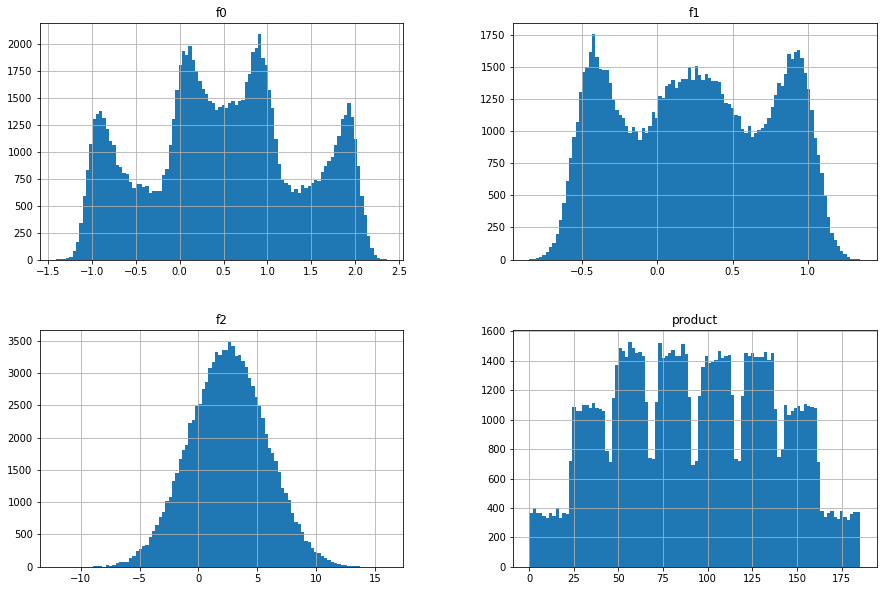

--------------------------------------------------------

Данные из файла geo_data_1.csv :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
94480,2vKcy,3.725029,-6.648298,4.994673,134.766305
30979,MpcRp,-2.188641,2.644041,3.996447,110.992147
16675,d94H5,-9.618124,1.483650,2.002485,57.085625
58498,UQs8w,2.151908,2.546658,5.003489,134.766305
823,IOcJ8,5.345455,-1.584767,0.995835,26.953261


Количество дубликатов: 0
Количество дубликатов в идентификаторах скважин: 4
Количество дубликатов в f0: 0
Количество дубликатов в f1: 0
Количество дубликатов в f2: 0
Количество дубликатов в product: 99988


,тип данных,описание
id,object,уникальный идентификатор скважины
f0,float64,признак точки №1
f1,float64,признак точки №2
f2,float64,признак точки №3
product,float64,объём запасов в скважине (тыс. баррелей)



Статистическая информация:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


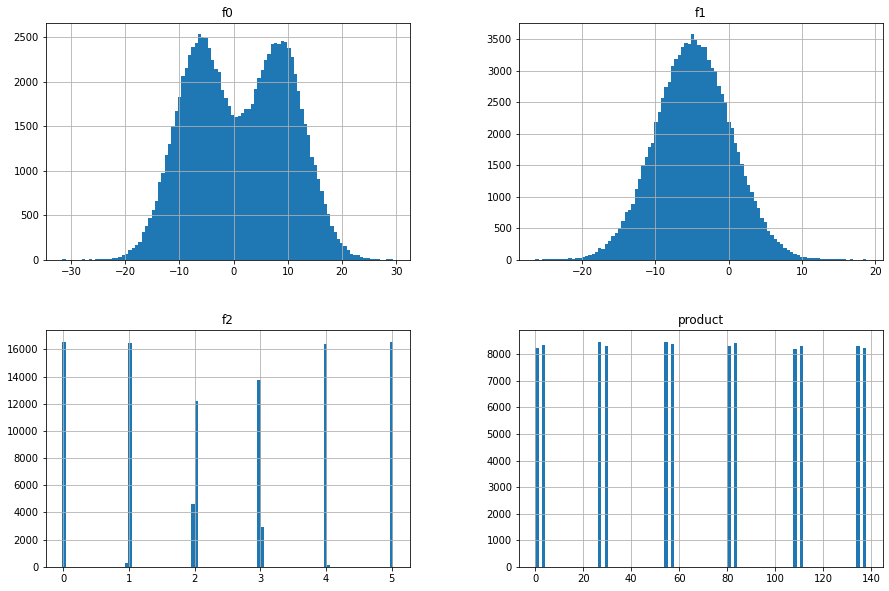

--------------------------------------------------------

Данные из файла geo_data_2.csv :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
23320,hK77l,0.475394,1.304403,0.697552,128.276588
49786,VrBni,1.262463,-0.553336,-1.239408,39.751623
62244,APNup,1.243054,0.398821,4.150498,78.106854
7351,5PCLC,-0.114206,1.534975,0.068090,7.474704
2090,hjZxc,-0.638112,-0.729532,9.550031,141.443101


Количество дубликатов: 0
Количество дубликатов в идентификаторах скважин: 4
Количество дубликатов в f0: 0
Количество дубликатов в f1: 0
Количество дубликатов в f2: 0
Количество дубликатов в product: 0


,тип данных,описание
id,object,уникальный идентификатор скважины
f0,float64,признак точки №1
f1,float64,признак точки №2
f2,float64,признак точки №3
product,float64,объём запасов в скважине (тыс. баррелей)



Статистическая информация:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


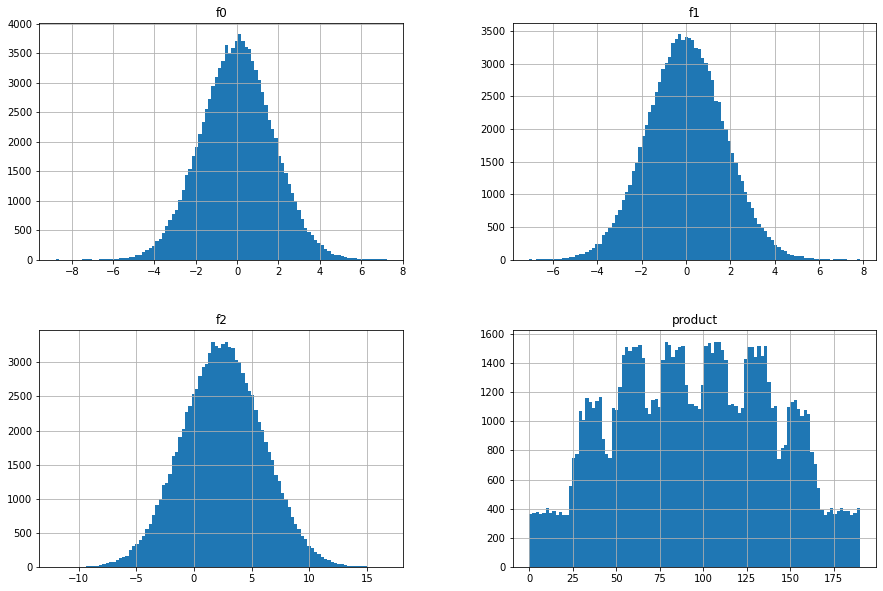

In [5]:
# загрузка и обзор данных в трех исходных файлах
data1 = zagr_obz('geo_data_0.csv')
data2 = zagr_obz('geo_data_1.csv')
data3 = zagr_obz('geo_data_2.csv')

Рассмотрев данные видим следующее:
- В каждом датасете по 100000 записей, этого достаточно для достоверного моделирования.
- Пропусков нет.
- Полных дубликатов строк нет.
- Типы столбцов данных соответствуют содержанию.
- Распределение значений параметров в первом и третьем датасетах адекватное.
- Отклонения:
    - В соответствии с заданием, `id` точек должны быть уникальными. По факту есть минимальное количество дубликатов по полю `id` во всех трех датасетах.
    - Во втором датасете в поле `product` содержатся почти 100% дубликатов. Это подтверждает график распределения значений данного параметра.
    - Во втором датасете распределение значений параметра `f2` аномально сгруппировано возле шести целочисленных значений.

Дубликаты в поле `id` посмотрим и если не найдем объяснения данному факту, то удалим. Их минимальное количество позволяет это сделать.

Откорректировать второй датасет, в котором поле `product` содержит почти 100% дубликатов и распределение значений параметра `f2` аномально, не представляется возможным. В реальной ситуации нужно уточнять и перезапрашивать исходные данные. В учебных целях не будем обращать на это внимание, строить модели будем для всех трех датасетов.

In [6]:
# смотрим дубликаты по полю 'id' во всех трех датасетах
display(data1[data1['id'].duplicated(keep=False)].sort_values(by='id').head(4))
display(data2[data2['id'].duplicated(keep=False)].sort_values(by='id').head(4))
display(data3[data3['id'].duplicated(keep=False)].sort_values(by='id').head(4))

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420


Понять причину появления данных дубликатов невозможно. Выбрать, какой из дубликатов оставить, также не представляется возможным. Поэтому удалим все дубликаты.

In [7]:
data1.drop_duplicates(subset='id', keep=False, inplace=True)
print('Количество дубликатов в идентификаторах скважин:', data1['id'].duplicated().sum())
data2.drop_duplicates(subset='id', keep=False, inplace=True)
print('Количество дубликатов в идентификаторах скважин:', data2['id'].duplicated().sum())
data3.drop_duplicates(subset='id', keep=False, inplace=True)
print('Количество дубликатов в идентификаторах скважин:', data3['id'].duplicated().sum())

Количество дубликатов в идентификаторах скважин: 0
Количество дубликатов в идентификаторах скважин: 0
Количество дубликатов в идентификаторах скважин: 0


Построим матрицы корреляции для трех датасетов.

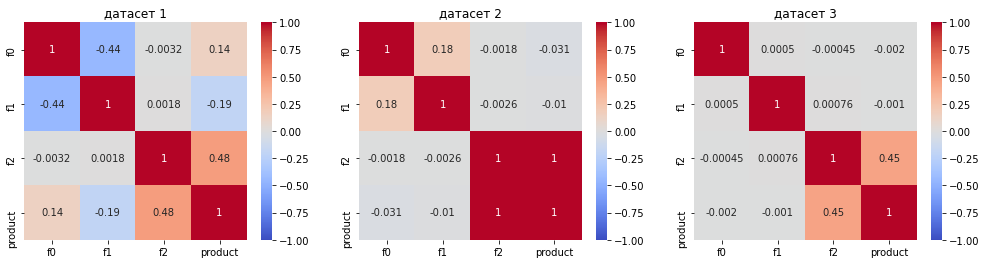

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(17, 4))
sns.heatmap(data1.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', ax=axes[0]).set(title='датасет 1')
sns.heatmap(data2.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', ax=axes[1]).set(title='датасет 2')
sns.heatmap(data3.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', ax=axes[2]).set(title='датасет 3')
plt.show()

Во втором датасете наблюдается 100% корреляция между параметрами `f2` и `product`. На аномальность данных во втором датае уже обращали внимание, в учебных целях вносить изменения не будем, будем использовать как есть.

### 1.1. <a id='toc1_1_'></a>[Вывод по разделу 1](#toc0_)

Исходные данные успешно загружены в три датасета. Их количество достаточно для построения моделей.

Пропусков в данных нет. Полных дубликатов нет. Типы столбцов данных соответствуют содержанию.

В рамках подготовки данных удалены дубликаты по полю `id`, так как это поле должно быть уникальным.

Данные в полях `f2` и `product` второго датасета, возможно, некорректны, но в учебных целях будем их использовать.

## 2. <a id='toc2_'></a>[Обучение и проверка модели](#toc0_)

Целевой признак `product` - объём запасов в скважине является количественным (числовым). Будем использовать модель линейной регрессии, как наиболее предсказуемую.

### 2.1. <a id='toc2_1_'></a>[Разбивка данных на выборки](#toc0_)

Разделим данные на обучающую и валидационную (тестовую) выборки в соотношении 75% и 25% соответственно.  
Целевая переменная - объём запасов в скважине (`product`).  
Параметры - `f0`, `f1`, `f2`.

Столбец `id` (уникальный идентификатор скважины) использовать при моделировании не будем.

In [9]:
print('\nРегион 1')
features_train1, features_test1, target_train1, target_test1 = viborki(data1)
print('\nРегион 2')
features_train2, features_test2, target_train2, target_test2 = viborki(data2)
print('\nРегион 3')
features_train3, features_test3, target_train3, target_test3 = viborki(data3)


Регион 1
    Обучающая выборка: 
        - параметры (строки, столбцы): (74985, 3)
        - целевая переменная (строки): (74985,)
    Валидационная (тестовая) выборка: 
        - параметры (строки, столбцы): (24995, 3)
        - целевая переменная (строки): (24995,)

Регион 2
    Обучающая выборка: 
        - параметры (строки, столбцы): (74994, 3)
        - целевая переменная (строки): (74994,)
    Валидационная (тестовая) выборка: 
        - параметры (строки, столбцы): (24998, 3)
        - целевая переменная (строки): (24998,)

Регион 3
    Обучающая выборка: 
        - параметры (строки, столбцы): (74994, 3)
        - целевая переменная (строки): (74994,)
    Валидационная (тестовая) выборка: 
        - параметры (строки, столбцы): (24998, 3)
        - целевая переменная (строки): (24998,)


### 2.2. <a id='toc2_2_'></a>[Обучение модели и предсказания](#toc0_)

Для каждого региона создадим и обучим модель линейной регресси, сделаем предсказания на валидационной (тестовой) выборке, определим средний запас предсказанного сырья и RMSE моделей.  
Подготовка признаков и подбор гиперпараметров не требуется.

In [10]:
print('\nРегион 1')
model1, predictions1 = modeli(features_train1, features_test1, target_train1, target_test1)
print('\nРегион 2')
model2, predictions2 = modeli(features_train2, features_test2, target_train2, target_test2)
print('\nРегион 3')
model3, predictions3 = modeli(features_train3, features_test3, target_train3, target_test3)


Регион 1
Средний запас сырья по предсказанным данным: 92.4
Средний запас сырья по реальным данным: 92.4
RMSE модели линейной регрессии на валидационной (тестовой) выборке: 37.7
R2 = 0.277

Регион 2
Средний запас сырья по предсказанным данным: 69.0
Средний запас сырья по реальным данным: 69.0
RMSE модели линейной регрессии на валидационной (тестовой) выборке: 0.9
R2 = 1.000

Регион 3
Средний запас сырья по предсказанным данным: 95.1
Средний запас сырья по реальным данным: 94.5
RMSE модели линейной регрессии на валидационной (тестовой) выборке: 40.0
R2 = 0.196


### 2.3. <a id='toc2_3_'></a>[Вывод по разделу 2](#toc0_)

- Наибольшие средние запасы сырья по предсказанным данным находятся в регионе № 3, наименьшие - в регионе № 2.
- Наименьшее значение RMSE у модели для региона № 2 (но помним о возможности влияния аномальных данных в этом датасете).

## 3. <a id='toc3_'></a>[Подготовка к расчёту прибыли](#toc0_)

По имеющейся информации:
- бюджет на разработку скважин в регионе составляет 10 млрд. рублей;
- по результатам отбора разрабатывается 200 скважин;
- один баррель сырья приносит 450 рублей дохода, соответственно, доход с каждой единицы продукта составляет 450 тыс. рублей.

Сохраним ключевые значения в переменных и рассчитайтаем достаточный объём сырья для безубыточной разработки новой скважины.

In [11]:
# ключевые значения
budget = 10000000000
kol_skvazhin = 200
dohod_ed = 450000

obyom_bezub = (budget / kol_skvazhin) / dohod_ed

print(f'Достаточный объём сырья для безубыточной разработки новой скважины составляет: {obyom_bezub:.1f} тыс. баррелей.')

Достаточный объём сырья для безубыточной разработки новой скважины составляет: 111.1 тыс. баррелей.


### 3.1. <a id='toc3_1_'></a>[Вывод по разделу 3](#toc0_)

В соответствии с расчетом, объём сырья, достаточный для безубыточной разработки новой скважины, составляет 111 тыс. баррелей. При этом средний запас сырья в скважинах по предсказанным данным в лучшем из регионов (регион № 3) составляет 95 тыс. баррелей.   
Чтобы обеспечить прибыльность проекта необходимо отбирать в каждом из регионов скважины с максимальным значением данного параметра.

## 4. <a id='toc4_'></a>[Расчёт прибыли и рисков](#toc0_)

Создадим функцию, которая из переданных ей данных выбирает 200 скважин с максимальным параметром запаса сырья по полученным предсказаниям, суммирует целевые значения объёмов сырья, соответствующее этим предсказаниям, и рассчитывает прибыль.


In [12]:
# функция расчета прибыли от скважин с максимальным запасом сырья
# на входе: предсказания, целевые значения в формате Series; на выходе: прибыль
# количество скважин, доход от единицы продукта и бюджет на разработку заранее сохранены в переменных
def raschet_prib(predictions, target):
    predictions = predictions.sort_values(ascending=False)
    obyom = target[predictions.index][:kol_skvazhin].sum()
    pribil = obyom * dohod_ed - budget
    return pribil

Применим технику `Bootstrap` с 1000 выборок, чтобы найти распределение прибыли.  
Для полученного распределения прибыли определим среднее значение, 95% доверительный интервал и риск получения убытка.

Реализуем в виде функции.

In [13]:
# функция реализации бутстрепа с вычислением среднего, 95% доверительного интервала и риска убытка
# на входе: предсказания и целевые значения для региона
# на выходе: средняя прибыль, две границы 95% доверительного интервала и риск получения убытка
# (в ходе выполнения вызывает функцию расчета прибыли `raschet_prib`)
def bootstr(pred, targ):
    state = np.random.RandomState(RST)
    profit = []
    targ = targ.reset_index(drop=True)
    pred = pd.Series(pred)
    for i in range(1000):
        targ_sub = targ.sample(n=500, replace=True, random_state=state)
        pred_sub = pred[targ_sub.index]
        profit.append(raschet_prib(pred_sub, targ_sub))

    profit = pd.Series(profit)
    prof_mean = profit.mean()
    lower = profit.quantile(0.025)
    upper = profit.quantile(0.975)
    loss = len(profit[profit < 0]) / 1000
    print(f'''
    Средняя прибыль: {prof_mean/1000000:.1f} млн. руб.
    95% доверительный интервал: от {lower/1000000:.1f} до {upper/1000000:.1f} млн. руб.
    Риск получения убытка составляет: {loss:.1%}.''')
    return prof_mean, lower, upper, loss

Применим созданные функции для всех трех регионов.

In [14]:
print('\nРегион 1')
prof_mean1, lower1, upper1, loss1 = bootstr(predictions1, target_test1)
print('\nРегион 2')
prof_mean2, lower2, upper2, loss2 = bootstr(predictions2, target_test2)
print('\nРегион 3')
prof_mean3, lower3, upper3, loss3 = bootstr(predictions3, target_test3)


Регион 1

    Средняя прибыль: 459.1 млн. руб.
    95% доверительный интервал: от -90.2 до 988.0 млн. руб.
    Риск получения убытка составляет: 4.7%.

Регион 2

    Средняя прибыль: 535.2 млн. руб.
    95% доверительный интервал: от 86.7 до 958.1 млн. руб.
    Риск получения убытка составляет: 1.4%.

Регион 3

    Средняя прибыль: 351.2 млн. руб.
    95% доверительный интервал: от -174.8 до 879.1 млн. руб.
    Риск получения убытка составляет: 11.4%.


### 4.1. <a id='toc4_1_'></a>[Вывод по разделу 4](#toc0_)

В соответствии с заданием:
- мы не должны рассматривать регионы в которых риск получения убытка выше 2,5%;
- из оставшихся после этого регионов необходимо выбрать регион с наибольшей средней прибылью.

Единственный регион, который соответствует этим требованиям, - это регион № 2.

## 5. <a id='toc5_'></a>[Общий вывод](#toc0_)

Данные загружены, выполнена небольшая предобработка с целью подготовки к дальнейшему исследованию. Размер каждой из выборок в 100 тысяч строк достаточен для проведения исследования.

Из исходных данных сформированы обучающая и валидационная (тестовая) выборки в соотношении 75% и 25% соответственно.  
В качестве модели взята линейная регрессия (как наиболее предсказуемая модель). Обучение моделей проводилось на обучающих выборках, подготовка параметров и подбор гиперпараметров не требовался.  
Наименьшее значение RMSE было получено у модели для региона № 2.  
Наибольшие средние запасы сырья по предсказанным данным находятся в регионе № 3.

Согласно расчетам, объём сырья, достаточный для безубыточной разработки новой скважины, составляет 111 тыс. баррелей. При этом средний запас сырья в скважинах по предсказанным данным в лучшем из регионов (регион № 3) составляет 95 тыс. баррелей.

Расчет прибыли и рисков проводился с использованием техники `bootstrap` на предсказаниях и валидационных (тестовых) выборках с учетом полученных в задании условий.  
По итогам расчетов, удовлетворяющим всем требованиям задания, определен регион № 2 со следующими характеристиками:
- средняя прибыль: 535.2 млн. руб.;
- 95% доверительный интервал: от 86.7 до 958.1 млн. руб.;
- риск получения убытка: 1.4%.

P.S.  
Следует ещё раз отметить, что в исходных данных региона № 2 поле `product` содержит почти 100% дубликатов, а значения параметра `f2` аномально сгруппированы возле нескольких дискретных значений.